In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Preprocessing
---

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Data for ML projects/flats_msk.xlsx')
df.shape

(200, 10)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df["district"] = ord_enc.fit_transform(df[["district"]])

In [ ]:
df.head()

,price,num_rooms,house_type,district,square,flat_floor,parking,balcony,height_ceiling,minutes_to_subway
0,15049234,2,1,3.0,63.20,3,0,0,2.87,10
1,16700000,3,0,4.0,66.00,2,0,1,2.87,7
2,17180000,2,0,3.0,53.45,2,1,0,2.70,18
3,19970000,3,0,4.0,94.70,7,1,1,2.80,51
4,24800000,3,0,3.0,75.70,3,1,0,2.70,19


Text(0.5, 0.98, 'Dependency of price with different variables')

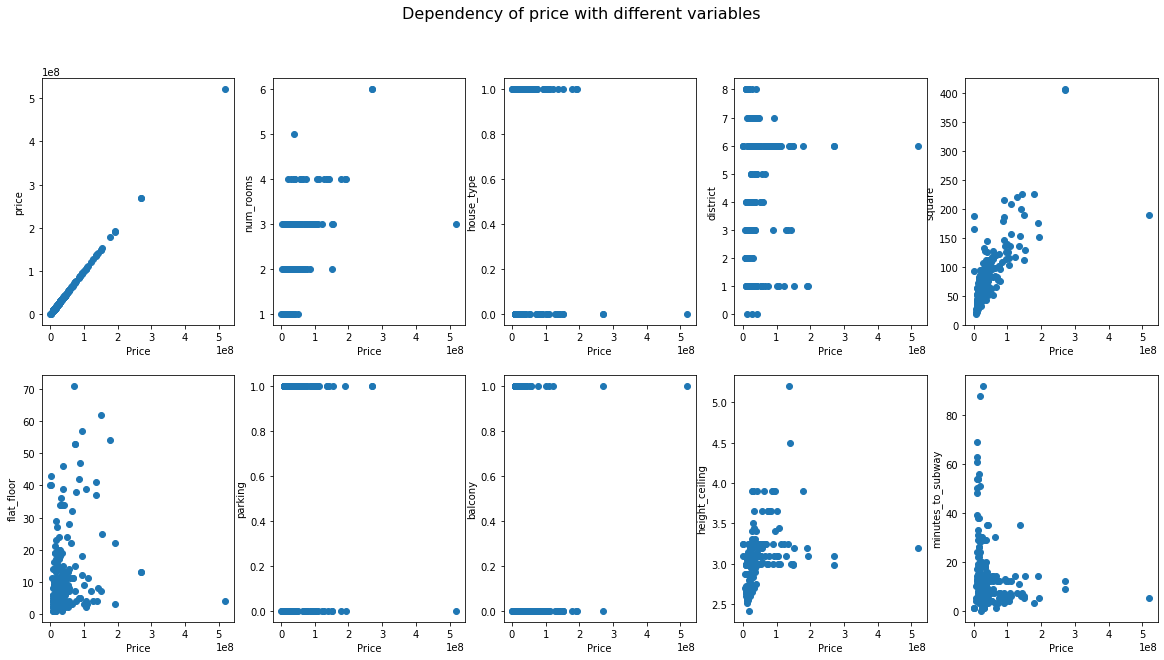

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
for i in range(5):
  ax[0][i].scatter(df.price, df[df.columns[i]])
  ax[0][i].set_ylabel(df.columns[i])
  ax[0][i].set_xlabel('Price')
for i in range(5):
  ax[1][i].scatter(df.price, df[df.columns[i+5]])
  ax[1][i].set_ylabel(df.columns[i+5])
  ax[1][i].set_xlabel('Price')

fig.suptitle('Dependency of price with different variables', fontsize=16)

Text(0.5, 0.98, 'Histogramms of variables')

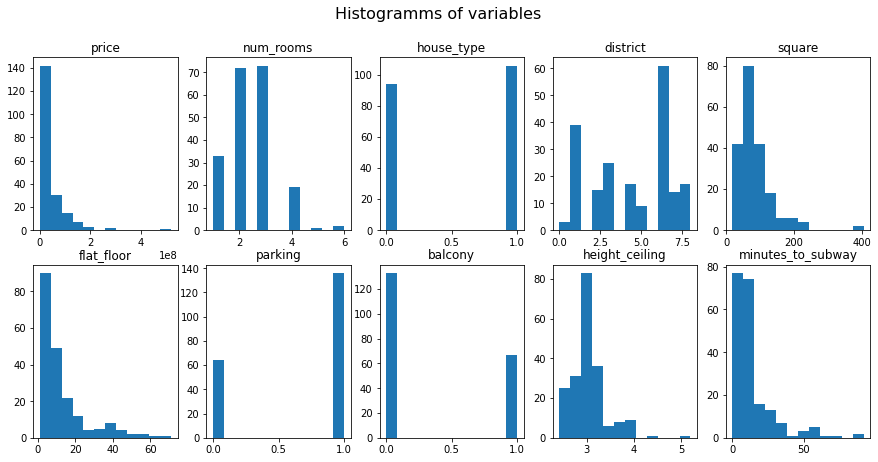

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15,7))
for i in range(5):
  ax[0][i].hist(x=df.columns[i],
                bins=12,
                data=df)
  ax[0][i].set_title(df.columns[i])
for i in range(5):
  ax[1][i].hist(x=df.columns[i+5],
                bins=12,
                data=df)
  ax[1][i].set_title(df.columns[i+5])

fig.suptitle('Histogramms of variables', fontsize=16)

In [ ]:
# sns.heatmap(df.corr(), annot=True)
# None

Text(0.5, 0.98, 'Boxplots of variables')

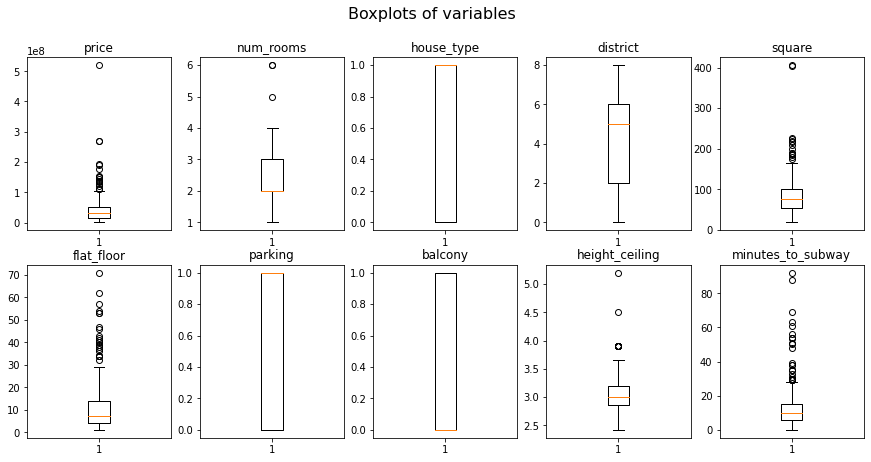

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15,7))
for i in range(5):
  ax[0][i].boxplot(x=df.columns[i],
                 data=df)
  ax[0][i].set_title(df.columns[i])
for i in range(5):
  ax[1][i].boxplot(x=df.columns[i+5],
                  data=df)
  ax[1][i].set_title(df.columns[i+5])

fig.suptitle('Boxplots of variables', fontsize=16)

In [ ]:
for column in df.columns:
  q1 = np.percentile(df[column], 25,
                    interpolation = 'midpoint')
  q2 = np.percentile(df[column], 75,
                    interpolation = 'midpoint')
  iqr = q2 - q1
  upper = q2 + 1.5*iqr
  lower = q1 - 1.5*iqr
  df = df[(df[column] > lower) & (df[column] < upper)]

In [ ]:
df = df[df.price < df.price.quantile(0.95)]
df.shape

(134, 10)

Text(0.5, 0.98, 'Boxplots of variables')

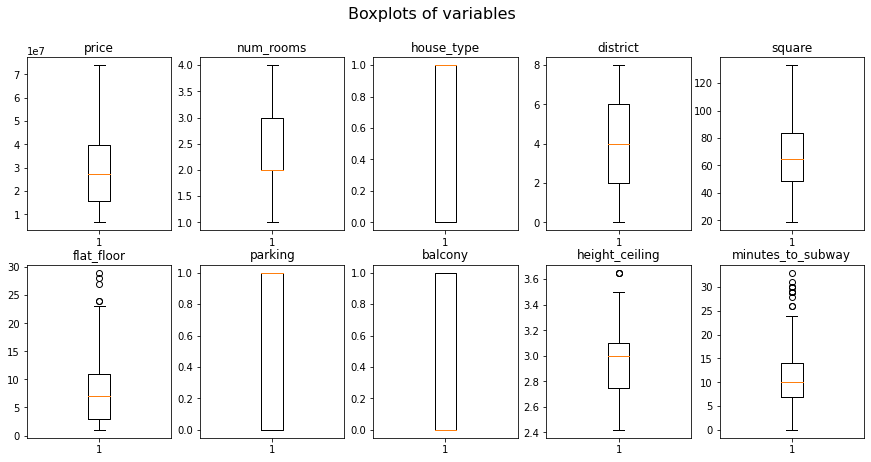

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15,7))
for i in range(5):
  ax[0][i].boxplot(x=df.columns[i],
                 data=df)
  ax[0][i].set_title(df.columns[i])
for i in range(5):
  ax[1][i].boxplot(x=df.columns[i+5],
                  data=df)
  ax[1][i].set_title(df.columns[i+5])

fig.suptitle('Boxplots of variables', fontsize=16)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (7,5))
sns.heatmap(df.corr(), annot=True, fmt='.0g', cmap='inferno')
None

NameError: ignored

<Figure size 504x360 with 0 Axes>

In [ ]:
res_df = df.drop(labels=['num_rooms', 'house_type', 'district', 'flat_floor', 'parking'], axis=1)

Preprocessing`s end
---

In [ ]:
from scipy.stats import shapiro
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy
import statsmodels.api as sm

Функции для построения модели и проверки на нормальность, мультиколлинеарность, гетероскедастичность и проверка теста Чоу
---

In [ ]:
def chow(path0, df0, path1, df1, path2, df2):
  J = df0.shape[1]
  k = df1.shape[1]
  N1 = df1.shape[0]
  N2 = df2.shape[0]
  model_dummy = smf.ols(path0, data=df0).fit()
  RSSd = model_dummy.ssr
  model_b = smf.ols(path1, data=df1).fit()
  RSSb = model_b.ssr
  model_nb = smf.ols(path2, data=df2).fit()
  RSSnb = model_nb.ssr
  chow = ((RSSd-(RSSb+RSSnb))/J)/((RSSb+RSSnb)/(N1+N2-2*k))
  print(f'Chow statistic: {chow}')
  print(f'P-value: {1 - scipy.stats.f.cdf(chow, J, N1+N2-2*k)}')

In [ ]:
def model_evaluation(path, df):
  model = smf.ols(path, data=df).fit()
  print(model.summary())
  print('-'*20)
  print(f'Shapiro test: {shapiro(model.resid)}')
  print('-'*20)
  names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value'] #BP test interpretation
  print(f'Breusch Pagan test: {sms.het_breuschpagan(model.resid, model.model.exog)}')
  print('-'*20)
  print(f'Durbin Watson test: {durbin_watson(model.resid)}')
  print('-'*20)
  
  y, X = dmatrices(path, data=df, return_type='dataframe')

  #calculate VIF for each explanatory variable
  vif = pd.DataFrame()
  vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['variable'] = X.columns
  print(f'VARIABLE INFLATION FACTOR: \n{vif.iloc[1:]}')
  print('-'*20)

In [ ]:
df.shape

(134, 10)

In [ ]:
model_evaluation('price ~  square +  balcony + height_ceiling + minutes_to_subway + num_rooms + house_type + district + flat_floor + parking', df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     40.45
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           8.54e-33
Time:                        16:34:33   Log-Likelihood:                -2320.3
No. Observations:                 134   AIC:                             4661.
Df Residuals:                     124   BIC:                             4689.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6.627e+07   1.11e+0

In [ ]:
model_evaluation('price ~  square +  balcony + height_ceiling', res_df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     120.3
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           2.43e-37
Time:                        16:40:10   Log-Likelihood:                -2323.0
No. Observations:                 134   AIC:                             4654.
Df Residuals:                     130   BIC:                             4666.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -6.747e+07    9.5e+06     -7.

In [ ]:
type_new_df = res_df[df.house_type == 1]
type_old_df = res_df[df.house_type == 0]

In [ ]:
chow('price ~  square +  balcony + height_ceiling', 
     res_df, 
     'price ~  square +  balcony + height_ceiling', 
     type_old_df, 
     'price ~  square +  balcony + height_ceiling', 
     type_new_df)

Chow statistic: 4.254977031320952
P-value: 0.001322929991072086
